https://examples.dask.org/xarray.html

In [5]:
%matplotlib inline

from dask.distributed import Client
import xarray as xr

In [2]:
client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
client

Client Scheduler: tcp://127.0.0.1:42745 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 2.00 GB


In [6]:
ds = xr.tutorial.open_dataset('air_temperature',
                              chunks={'lat': 25, 'lon': 25, 'time': -1})
ds

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 dask.array<chunksize=(2920, 25, 25), meta=np.ndarray>
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [7]:
da = ds['air']
da

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
dask.array<open_dataset-7812d461f65399eb3eb1d7ee8e99cc39air, shape=(2920, 25, 53), dtype=float32, chunksize=(2920, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [5]:
da.data

dask.array<open_dataset-7812d461f65399eb3eb1d7ee8e99cc39air, shape=(2920, 25, 53), dtype=float32, chunksize=(2920, 25, 25), chunktype=numpy.ndarray>

In [6]:
da2 = da.groupby('time.month').mean('time')
da3 = da - da2
da3

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53, month: 12)>
dask.array<sub, shape=(2920, 25, 53, 12), dtype=float32, chunksize=(2920, 25, 25, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [7]:
computed_da = da3.load()
type(computed_da.data)

numpy.ndarray

In [8]:
da = da.persist()

In [9]:
da.resample(time='1w').mean('time').std('time')

<xarray.DataArray 'air' (lat: 25, lon: 53)>
dask.array<sqrt, shape=(25, 53), dtype=float32, chunksize=(25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0

In [4]:
da_smooth = da.rolling(time=30).mean().persist()
da_smooth

NameError: name 'da' is not defined

In [12]:
import numpy as np
import xarray as xr
# import bottleneck

def covariance_gufunc(x, y):
    return ((x - x.mean(axis=-1, keepdims=True))
            * (y - y.mean(axis=-1, keepdims=True))).mean(axis=-1)

def pearson_correlation_gufunc(x, y):
    return covariance_gufunc(x, y) / (x.std(axis=-1) * y.std(axis=-1))

def spearman_correlation_gufunc(x, y):
    x_ranks = bottleneck.rankdata(x, axis=-1)
    y_ranks = bottleneck.rankdata(y, axis=-1)
    return pearson_correlation_gufunc(x_ranks, y_ranks)

def spearman_correlation(x, y, dim):
    return xr.apply_ufunc(
        spearman_correlation_gufunc, x, y,
        input_core_dims=[[dim], [dim]],
        dask='parallelized',
        output_dtypes=[float])

In [13]:
corr = spearman_correlation(da.chunk({'time': -1}),
                            da_smooth.chunk({'time': -1}),
                            'time')
corr

<xarray.DataArray (lat: 25, lon: 53)>
dask.array<spearman_correlation_gufunc, shape=(25, 53), dtype=float64, chunksize=(25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0

In [15]:
from scipy import stats

In [13]:
da[:,0,0]

<xarray.DataArray 'air' (time: 2920)>
dask.array<getitem, shape=(2920,), dtype=float32, chunksize=(2920,), chunktype=numpy.ndarray>
Coordinates:
    lat      float32 75.0
    lon      float32 200.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

/home/lalandmi/miniconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


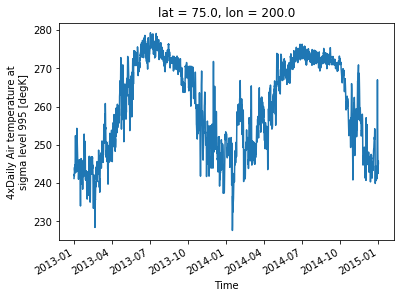

In [19]:
da[:,0,0].plot()

In [28]:
da

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
dask.array<open_dataset-7812d461f65399eb3eb1d7ee8e99cc39air, shape=(2920, 25, 53), dtype=float32, chunksize=(2920, 25, 25), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

In [35]:
stats.linregress(range(2920), da[:,0,0])

LinregressResult(slope=0.0025542701999320097, intercept=256.64847696937113, rvalue=0.18328565586869222, pvalue=1.7790053861453932e-23, stderr=0.00025361539140362317)

In [63]:
%%time

res = da[0].copy()
res.load()

for lat in range(25):
    for lon in range(53):
        res[lat,lon] = stats.linregress(range(2920), da[:,lat,lon]).slope

CPU times: user 12.2 s, sys: 207 ms, total: 12.4 s
Wall time: 2.07 s


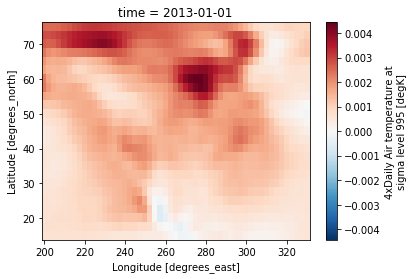

In [65]:
res.plot()

In [66]:
%%time

res_dask = da[0].copy()
res_dask.load()

res_dask = xr.apply_ufunc(scipy.stats.linregress, range(2920), da.load(),
        input_core_dims=[['time'], ['time']],
        output_core_dims=[[], [], [], [], []],
        vectorize=True)


CPU times: user 2 s, sys: 0 ns, total: 2 s
Wall time: 335 ms


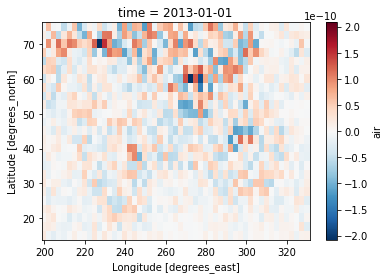

In [75]:
(res_dask[0]-res).plot()

In [ ]:
LinregressResult(slope=0.0025542701999320097, intercept=256.64847696937113, rvalue=0.18328565586869222, pvalue=1.7790053861453932e-23, stderr=0.00025361539140362317)

In [82]:
# add the data to the existing dataset
for arr_name, arr in zip(['slope', 'intercept', 'rvalue', 'pvalue', 'stderr'], res_dask):
    da[arr_name] = arr

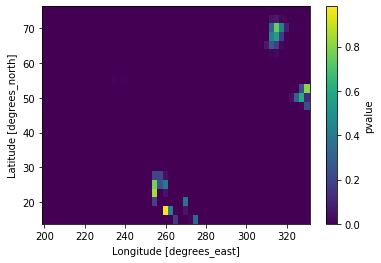

In [88]:
da.pvalue.plot()

In [14]:
corr.plot(figsize=(12, 8))

NameError: name 'bottleneck' is not defined